# Import libraries and data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python


In [3]:
#import libraries
import xgboost as xgb
import itertools
from prophet import Prophet
import pandas as pd
import numpy as np

In [4]:
#get the data
data = pd.read_csv("Daily Bike Sharing.csv")
data.head(1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [5]:
#select variables
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1)                       

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#Data Transformation

In [6]:
#Date variable
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [7]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#holidays

In [8]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday' : 'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [9]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


#Training and Test Set

In [10]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846


#Facebook Prophet

In [11]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.01)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_daenm5_/8dhsk0b6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_daenm5_/9mjgcr0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75132', 'data', 'file=/tmp/tmp_daenm5_/8dhsk0b6.json', 'init=/tmp/tmp_daenm5_/9mjgcr0a.json', 'output', 'file=/tmp/tmpu2_lor7_/prophet_model-20220830092830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:28:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:28:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#forecasting 

In [12]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [13]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [14]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2464.781042,248.456344,2160.333113,2464.781042,2464.781042,-0.055153,-0.055153,-0.055153,-0.283583,...,0.000000,0.000000,0.000000,-0.266583,-0.266583,-0.266583,0.0,0.0,0.0,1244.764078
1,2011-01-02,2470.205925,100.204397,1959.559237,2470.205925,2470.205925,-0.059795,-0.059795,-0.059795,-0.291137,...,0.000000,0.000000,0.000000,-0.259540,-0.259540,-0.259540,0.0,0.0,0.0,1002.840665
2,2011-01-03,2475.630807,404.621445,2222.953307,2475.630807,2475.630807,-0.136960,-0.136960,-0.136960,-0.196844,...,0.029157,0.029157,0.029157,-0.251190,-0.251190,-0.251190,0.0,0.0,0.0,1304.434943
3,2011-01-04,2481.055690,458.808039,2320.306706,2481.055690,2481.055690,-0.126293,-0.126293,-0.126293,-0.187623,...,0.029157,0.029157,0.029157,-0.241658,-0.241658,-0.241658,0.0,0.0,0.0,1416.799861
4,2011-01-05,2486.480572,620.653442,2547.267438,2486.480572,2486.480572,-0.118241,-0.118241,-0.118241,-0.119130,...,0.029157,0.029157,0.029157,-0.231092,-0.231092,-0.231092,0.0,0.0,0.0,1604.593894


#XGBoost preparation

In [15]:
prophet_variables = forecast.loc[:, ["trend", "holi", "weekly", "yearly"]]
df_xgb = pd.concat([dataset, prophet_variables], axis = 1)
df_xgb.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2464.781042,0.0,0.055186,-0.266583
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2470.205925,0.0,-0.043348,-0.259540
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2475.630807,0.0,-0.025056,-0.251190
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2481.055690,0.0,0.000328,-0.241658
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2486.480572,0.0,-0.004450,-0.231092


In [16]:
#Training and test set
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846,6424.90503,0.0,-0.025056,-0.269581


In [17]:
#isolate X and Y
y_train = training_set.y
y_test = test_set.y
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [18]:
#create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

#XGBoost

In [19]:
#Set the parameters
parameters = {'learning_rate': 0.1,
              'max_depth': 3,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

In [20]:
#XGBoost Model
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100,
                  evals = [(Test, "y")],
                  verbose_eval = 15)

[0]	y-rmse:3891.59
[15]	y-rmse:1579.18
[30]	y-rmse:1355.26
[45]	y-rmse:1277.92
[60]	y-rmse:1229.77
[75]	y-rmse:1215.69
[90]	y-rmse:1211.19
[99]	y-rmse:1198.81


#Forecasting and Visualization

In [21]:
#Forecasting
predictions_xgb = pd.Series(model.predict(Test), name = "XGBoost")
predictions_xgb.index = test_set.ds
predictions_xgb[:2]

ds
2012-12-01    3945.443359
2012-12-02    2902.847168
Name: XGBoost, dtype: float32

In [22]:
#set up index
training_set.index = training_set.ds
test_set.index = test_set.ds

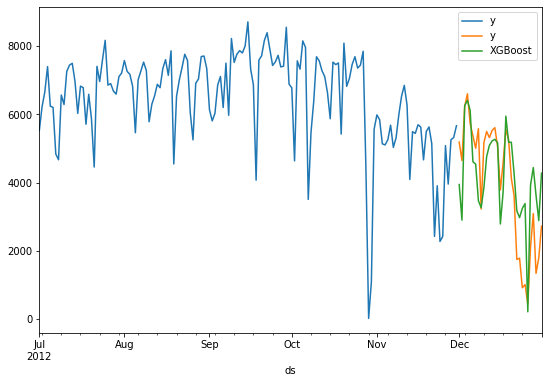

In [23]:
#Viz
training_set.y['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

#Model assessment

In [24]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(round(mean_absolute_error(test_set['y'], predictions_xgb),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_xgb)), 0))
print(mean_absolute_percentage_error(test_set['y'], predictions_xgb))

958.0
1199.0
0.4493691416733891


In [25]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_xgb)

44.93691416733891

#export forecasts

In [26]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble


In [27]:
predictions_xgb.to_csv('predictions_xgb.csv', index = True)